## Competition Predictions

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as pl
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Activation, Conv2D, Flatten, MaxPooling2D, AveragePooling2D, LeakyReLU, concatenate
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow import clip_by_value
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
import pickle
import pyarrow as pa
import pyarrow.parquet as pq
import gc
import datetime

The MNIST digit images are of 28x28x1 dimension.  I'll store the dimension size of 28 for reference later in the script for neural network input dimension as well as array reshaping.

In [2]:
pic_size = 28

Here I'll load the training data and split it into feature (X) and target (y) arrays.  Then I'll do two things:
 - Reshape X into a (n,28,28,1) numpy array
 - Convert y into a (n,10) one-hot encoded numpy array

In [3]:
base_path = 'C:\\Users\\rbush\\Documents\\Projects\\Computer Vision\\MNIST\\Data'

In [4]:
train = pd.read_csv(base_path+'\\train.csv', header=0)
test = pd.read_csv(base_path+'\\test.csv', header=0)

In [5]:
X, y = train.iloc[:,1:len(train.columns)], train.iloc[:,0]

In [6]:
X = np.array(X).reshape(X.shape[0], pic_size, pic_size, 1)
y = to_categorical(np.array(y))

To bolster the model's ability to generalize to other handwritten digits, I'll use Keras' ImageDataGenerator to generate artificial training samples which are:
- Rotated +/- 20 degrees or 
- Shifted horizontally or vertically by 7.5% of the image dimension.

In [7]:
mnist_gen = ImageDataGenerator(rotation_range=20, 
                               height_shift_range=0.075, 
                               width_shift_range=0.075)
mnist_gen.fit(X)

Before running the image augmentation, there are 42,000 images in the training dataset.

In [8]:
print(X.shape,y.shape)

(42000, 28, 28, 1) (42000, 10)


In [9]:
X_orig, y_orig = X, y
for i in range(3):
    train_aug = mnist_gen.flow(X_orig, y_orig, batch_size=int(X_orig.shape[0])).next()
    X_aug, y_aug = train_aug[0], train_aug[1]
    X = np.concatenate([X, X_aug])
    y = np.concatenate([y, y_aug])

After generating 3 batches of augmented images, the new training dataset has 168,000 records.

In [10]:
print(X.shape, y.shape)

(168000, 28, 28, 1) (168000, 10)


Below you can see a sample of 25 images pulled from the augmented dataset:

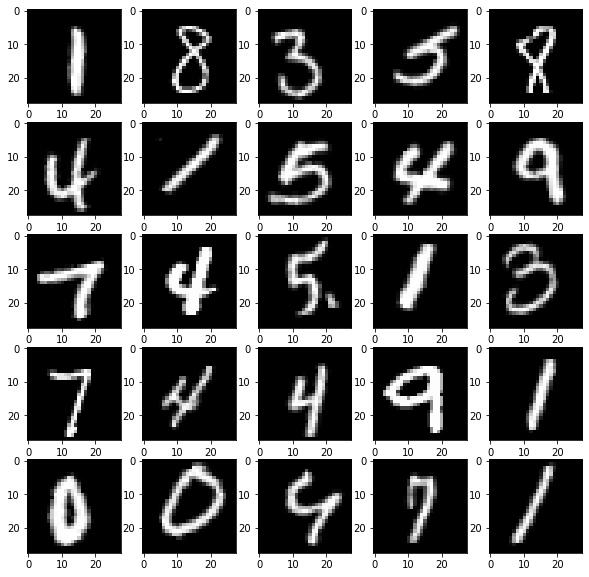

In [11]:
sample_indices = np.random.choice(X.shape[0], 25, replace=False)
sample_arrays = X[sample_indices]
cpt = 0
i = 0
pl.figure(0, figsize=(10,10))
for row in range(5):
    for col in range(5):
        cpt += 1
        pl.subplot(5,5,cpt)
        img = array_to_img(sample_arrays[i].reshape(pic_size,pic_size,1))
        pl.imshow(img, cmap='gray')
        i += 1
pl.show()

The model I used is a custom architecture inspired by the infamous LeNet-5 convolutional neural network: 

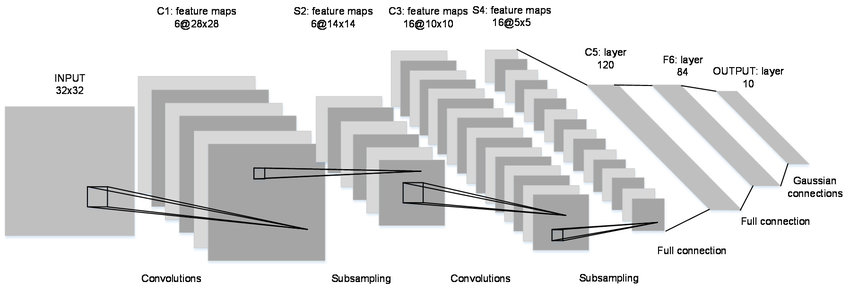

The LeNet-5 network followed the principle of applying convolutional and pooling layers in sequence to identify features, and then feeding that flattened output to dense layers for prediction.  I followed that principle and chose the following architecture:
 - Two 100-filter 7x7 hidden convolutional layers which are lightly L2-regularized, and two 200-filter 4x4 convolutional hidden layers which do not have their weights regularized.
 - Following each hidden convolutional layer, there is a 2x2 max-pooling layer, followed by 50% dropout and batch normalization layers.
 - After the convolutions are applied, the output from the final convolutional batch normalization layer is flattened and fed to 2 dense hidden layers.
 - The first dense hidden layer has 256 nodes, and the second has 128.  Following each dense layer, 50% dropout and batch normalization are applied.
 - Finally, the output from the hidden layers are fed to an output dense layer of dimension 10 which uses a softmax activation function to make its predictions.

In [12]:
cnn_input = Input(shape=(pic_size,pic_size,1))
x = Conv2D(100, kernel_size=7, activation='relu', kernel_regularizer=l2(0.0005))(cnn_input)
x = Conv2D(100, kernel_size=7, activation='relu', kernel_regularizer=l2(0.0005))(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv2D(200, kernel_size=4, activation='relu')(x)
x = Conv2D(200, kernel_size=4, activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
cnn_output = Dense(y.shape[1], activation='softmax')(x)

In [13]:
cnn = Model(inputs=[cnn_input], outputs=cnn_output)

I've trained my model for over 200 epochs, and even with a GPU that took some time.  Below I'll load the trained model and fit it on 5 more epochs for demonstration purposes.

In [14]:
cnn = keras.models.load_model('C:\\Users\\rbush\\Documents\\Projects\\Computer Vision\\MNIST\\Models\\Convolutional Model.h5')

In [15]:
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In my hyperparameter selection and tuning process, I used Keras' ReduceLROnPlateau tuner to identify optimal learning rates as I performed cross-validation.  Below I've hard-coded a schedule that worked particularly well for me.  I've left it in here if you're interested to take a look.

In [16]:
def lr_schedule_fun(epoch):
    if (epoch >= 0 and epoch < 45):
        return 5e-6# 3e-4  3e-4 is the actual starting point, but I'm commenting it out and adding 7e-6 for the demonstration
    elif (epoch >= 45 and epoch < 60):
        return 2.25e-4
    elif (epoch >= 60 and epoch < 70):
        return 1.6875e-4
    elif (epoch >= 70 and epoch < 80):
        return 1.2656e-4
    elif (epoch >= 80 and epoch < 90):
        return 9.4922e-5
    elif (epoch >= 90 and epoch < 95):
        return 7.1191e-5
    elif (epoch >= 95 and epoch < 100):
        return 5.3394e-5
    elif (epoch >= 100 and epoch < 110):
        return 4.0045e-5
    elif (epoch >= 110 and epoch < 120):
        return 3.0034e-5
    elif (epoch >= 120 and epoch < 130):
        return 2.2525e-5
    elif (epoch >= 130 and epoch < 135):
        return 1.6894e-5
    elif (epoch >= 135 and epoch < 140):
        return 1.2671e-5
    elif (epoch >= 140 and epoch < 150):
        return 9.5029e-6
    elif (epoch >= 150 and epoch < 160):
        return 7e-6
    elif epoch >= 160:
        return 5.25e-6

In [17]:
lr_schedule = LearningRateScheduler(lr_schedule_fun)

In [18]:
cnn.fit(X, y, batch_size=200, epochs=5, callbacks=[lr_schedule])

Epoch 1/5
840/840 [==============================] - 51s 54ms/step - loss: 0.0032 - accuracy: 0.9995 - lr: 5.0000e-06
Epoch 2/5
840/840 [==============================] - 50s 59ms/step - loss: 0.0034 - accuracy: 0.9995 - lr: 5.0000e-06
Epoch 3/5
840/840 [==============================] - 52s 62ms/step - loss: 0.0033 - accuracy: 0.9995 - lr: 5.0000e-06
Epoch 4/5
840/840 [==============================] - 51s 61ms/step - loss: 0.0032 - accuracy: 0.9996 - lr: 5.0000e-06
Epoch 5/5
840/840 [==============================] - 52s 61ms/step - loss: 0.0032 - accuracy: 0.9996 - lr: 5.0000e-06


In [19]:
cnn.save('C:\\Users\\rbush\\Documents\\Projects\\Computer Vision\\MNIST\\Models\\Convolutional Model.h5')

And now for the predictions!

In [20]:
X_pred = np.array(test).reshape(test.shape[0], pic_size, pic_size, 1)

In [21]:
predictions = np.argmax(cnn.predict(X_pred), axis=1)

In [22]:
submission_df = pd.DataFrame(predictions).reset_index()

In [23]:
submission_df.rename(columns={'index':'ImageID', 0:'Label'}, inplace=True)

In [24]:
submission_df['ImageID'] += 1

In [25]:
submission_df.set_index('ImageID', inplace=True)

In [26]:
submission_df.to_csv('C:\\Users\\rbush\\Documents\\Projects\\Computer Vision\\MNIST\\Submission\\Digit Recognizer Submission_20211201.csv')

This approach earned me a top 7% finish on the Kaggle leaderboard, which corresponds to a 99.628% accurate classifcation rate.  I'm pleased with the results, but feel that I could break the top 100 with a few additional tweaks:
- using the OpenCV library for some of its advanced image augmentation features.  Specifically, the morphology application allows you to "sharpen" the images such that they are less (or more) pixelated.  That is an augmentation I'm not able to do with Keras' ImageDataGenerator.
- run a bunch more batches of the data augmentation in this notebook on the trained model.  If I were to run 20-30 more iterations of 20 epochs on a low learning rate, I suspect I could achieve much higher results by giving the model a better perspective on the population variance of the image dataset.